## Kaggle Digit Recognition with Neural Networks

This exercise looks at the use of Neural Networks to recognize handwritten digits. In summary, the worse performing Neural network recognized the digits 97.5% of the time and performed better than the best classifier result at 96.4% accuracy.

We start with a training set of 42,000 handwritten numbers which have been labelled. The Exploratory data analysis identifies that the numbers are not evenly distributed, with more of the digits 1, 3 and 7 and less of the digit 5. We also identify that there are a significant number of pixels where the values are 0 or 255 across all images and these can be removed from the data set. 

The analysis finds that using 4 dense layers with 392 nodes run in 10 epochs provided the highest score and lowest times. There was no improvement in kaggle score from raising the number of epochs even though model accuracy and validation accuracy improved. Surprisingly, raising the number of layers or nodes resulted in lower results.

We were failed to improve the kaggle score by increasing the nodes and layers, we attempted a mode sophisticated model using the Conv2D convolutional layer and increasing the number of layers. This appeared to provde a lower accuracy, but ended up providing a better score that the increased layers/nodes though it was not able to do better than the original 10 epoch, 4 dense layer model.

This python notebook and a html version can be found at Github at https://github.com/ShawnTayNWU/MSDS422/blob/master/Digit2_vFinal.html or https://github.com/ShawnTayNWU/MSDS422/blob/master/Digit2_vFinal.ipynb

|Model|Type|Layers|Nodes|Epochs|Time|Cat Accuracy|Val Accuracy|Kaggle Score|
|---|---|---|---|---|---|---|---|---|
|1|Dense|4|392|10|00m 40s|0.9938|0.9733|0.97528|
|2|Dense|4|392|30|02m 19s|0.9974|0.9781|0.97528|
|3|Dense|6|392|30|03m 19s|0.9963|0.9743|0.97185|
|4|Dense|4|784|30|06m 23s|0.9957|0.9776|0.97185|
|5|Dense+Conv2D|10|32|30|57:47m|0.97514|0.1069|0.97514|

### Load Packages

In [2]:
# Basic dataframe, array, and math stuff
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport as pp

#Basic Operating System Stuff
import os
import random #random seed generator
from numpy.random import seed
seed(1234)


#Timer
from timeit import default_timer as timer #import a timer
from datetime import datetime

# mnist
from mnist.loader import MNIST

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# Keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


#Scikit learn
from sklearn.preprocessing import StandardScaler # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler # used for variable scaling data

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as srch

#Graphing
import seaborn as sns
import pydot  #For model plotting
from IPython.display import SVG #For model plotting
from IPython.display import display #For model plotting
import matplotlib.pyplot as plt #plotting
import matplotlib as mpl #image save
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import image as mpimg
from matplotlib.pyplot import imshow #Show images
from PIL import Image #Another image utility
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Set rows and columnns for display so that we can see more than just 10 rows from print
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

# Set seaborn charts to seaborn default settings
sns.set()



Using TensorFlow backend.


### Load Data

In [3]:
train = pd.read_csv('../digit/train.csv')
test = pd.read_csv('../digit/test.csv')

## Exploratory Data Analysis

The EDA identifies that the first column in the data set is a label showing the number, and that there are 784 columns showing the intensity of the colour in a single pixel. Pixels are labelled pixel0 to pixel 783. 

There are 42000 rows of data, all with a numeric data type, so there are no categorical values in this analysis. There are now null rows in the data, so there is no need for imputation.

An interesting finding is that the numbers are not evenly distributed. It appears that there are significantly more 1s, 3s and 7s then there are 5s.

A look at the sample of numbers shows that some pixels (for example in the corners) may be black or white every digit. 

A review of the description of the data shows that there are pixels where the min, mean and max are 0 or 255, showing the pixels that are either completely black or completely white in every digit image. These pixels can be removed from the analysis.



### Copy train data to avoid modifying it for EDA

In [4]:
df = train.copy()
df_test=test.copy()

### Overview of data
First column shows number, other 784 columns show pixel colour depth

In [5]:
display(df.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Shape of data
Training data: 1 label column, 784 pixel columns, 42000 numbers
Testing data: 784 pixel columns, 28000 numbers

In [6]:
display(df.shape)

(42000, 785)

In [7]:
display(df_test.shape)

(28000, 784)

### Data info
Data shows 1 label entry, and other entries are listed to pixel 783

In [8]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


None

### Check for Null Values
No Null Values

In [9]:
#NaN values in the dataset ?

nan = df.isnull().sum()
print(nan[nan != 0])

Series([], dtype: int64)


### Look at distribution of numbers
Looks like the distribution set is significantly biased towards 1, 3 and 7 and against 5.

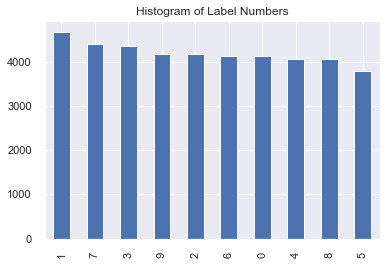

In [10]:
#Distribution of the digits in the dataset
Digit_Dist = df['label'].value_counts().plot(kind='bar')
plt.title('Histogram of Label Numbers')
plt.show()


### Show sample of handwritten digit images
Show image for 24 digits and the corresponding label

Handwritten picked-up digits:  [3 2 9 7 9 0 9 9 5 7 4 8 6 0 9 2 2 4 1 8 7 3 0 1]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



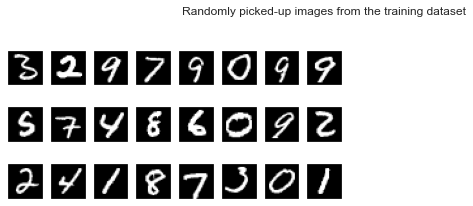

''

In [11]:
# Displays a designated number of handwritten digit images
# source: https://www.kaggle.com/damienbeneschi/mnist-eda-preprocessing-classifiers

def display_digits(N):
    """Picks-up randomly N images within the 
    train dataset between 0 and 41999 and displays the images
    with 4 images/row"""
    
    images = np.random.randint(low=0, high=42001, size=N).tolist()
  
    
    subset_images = df.iloc[images,:]
    subset_images.index = range(1, N+1)
    print("Handwritten picked-up digits: ", subset_images['label'].values)
    subset_images.drop(columns=['label'], inplace=True)

    for i, row in subset_images.iterrows():
        plt.subplot((N//8)+1, 8, i)
        pixels = row.values.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.title('Randomly picked-up images from the training dataset', y=5)
    plt.show()

    return ""

display_digits(24)

### Look at pixel intensities
A lot of pixels where the data is 0 across all 42000 images. We could drop these pixels.
Also, it appears maximum intensity is 255

In [12]:
#Analyse the pixels intensities
subset_pixels = df.iloc[:, 1:]
subset_pixels.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,0.174119,0.191310,0.190595,0.196048,0.171357,0.164476,0.151714,0.105310,0.060786,0.045071,0.015405,...,0.503095,1.146333,2.161786,3.243452,4.637214,5.979500,6.605095,6.443595,5.681095,4.656952,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,5.810949,5.995212,5.910242,6.024478,5.726352,5.515774,5.436431,4.478486,3.457538,2.933291,1.598329,...,9.617457,14.813496,20.680863,25.122322,30.096075,34.136445,35.807719,35.121494,33.020299,29.711767,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

## Transform Data and Run Analysis

We seperate the data in test and train, after which we fit transform the predictor(X) variables using the min max scaler and the target (Y) variables using Keras to convert Y to categoricals.

We ran a variety of models which are detailed in the analysis summary.

### Create Training and test data

In [50]:
# Create data matrices

# Re-Read the data
train = pd.read_csv('../digit2/train.csv')
test = pd.read_csv("../digit2/test.csv")

X_test=test

# Define Y_Train
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=1234)


In [51]:
# Check to make sure data is correct shape
# Train should have 42,000 rows and Test should have 28000 rows
# Number of columns should match "remaining pixels" from the pixel removal
# y_train should have 42,000 rows and 1 column

display(X_train.shape)
display(Y_train.shape)
display(X_val.shape)
display(Y_val.shape)
display(X_test.shape)

(37800, 784)

(37800,)

(4200, 784)

(4200,)

(28000, 784)

In [52]:
ss = StandardScaler()
mms= MinMaxScaler()

X = mms.fit_transform(X_train)
X = np.array(X)

X_val=mms.fit_transform(X_val)
X_val=np.array(X_val)

X_test=mms.fit_transform(X_test)
X_test=np.array(X_test)

keras_Y=tf.keras.utils.to_categorical(Y_train,10)
keras_Y_val=tf.keras.utils.to_categorical(Y_val,10)

In [53]:
display(keras_Y.shape)
display(keras_Y_val.shape)

(37800, 10)

(4200, 10)

### Neural Network 1 - 4 Dense Layers, 10 Epochs

Our first attempt uses the model as defined in the class. The score on kaggle is 0.97528, an improvement of the 0.96442 achived with the PCA and random forest classification method.

In [55]:
start=datetime.now()
model=tf.keras.Sequential()
model.add(layers.Dense(392,input_dim=784,activation='relu'))
model.add(layers.Dense(392,activation='relu'))
model.add(layers.Dense(392,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['categorical_accuracy'])
history=model.fit(X,keras_Y, epochs=10, validation_data=(X_val, keras_Y_val))
end=datetime.now()
print("time:", end-start) 

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 4s 110us/sample - loss: 0.2291 - categorical_accuracy: 0.9300 - val_loss: 0.1383 - val_categorical_accuracy: 0.9593
Epoch 2/10
37800/37800 [==============================] - 4s 104us/sample - loss: 0.1019 - categorical_accuracy: 0.9686 - val_loss: 0.1187 - val_categorical_accuracy: 0.9643
Epoch 3/10
37800/37800 [==============================] - 4s 103us/sample - loss: 0.0726 - categorical_accuracy: 0.9772 - val_loss: 0.1261 - val_categorical_accuracy: 0.9652
Epoch 4/10
37800/37800 [==============================] - 4s 103us/sample - loss: 0.0541 - categorical_accuracy: 0.9837 - val_loss: 0.1108 - val_categorical_accuracy: 0.9700
Epoch 5/10
37800/37800 [==============================] - 4s 104us/sample - loss: 0.0450 - categorical_accuracy: 0.9864 - val_loss: 0.1092 - val_categorical_accuracy: 0.9702
Epoch 6/10
37800/37800 [==============================] - 4s 104us/sample - loss:

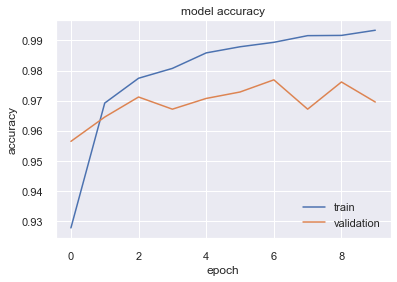

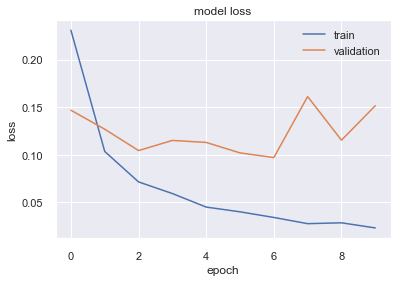

In [19]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [20]:
model_Pred=(model.predict(X_test))
results = np.argmax(model_Pred,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('../digit2/model1_Pred.csv',index=False)

### Neural Network 2  - 4 Dense Layers, 30 Epochs
Run with 30 epochs like in class example. 

The score on kaggle is 0.97528, the same as with 10 epochs, so increasing the epochs resulted in no additional increase in accuracy

In [57]:
start=datetime.now()
model2=tf.keras.Sequential()
model2.add(layers.Dense(392,input_dim=784,activation='relu'))
model2.add(layers.Dense(392,activation='relu'))
model2.add(layers.Dense(392,activation='relu'))
model2.add(layers.Dense(10,activation='softmax'))
model2.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['categorical_accuracy'])
history2=model2.fit(X,keras_Y, epochs=30, validation_data=(X_val, keras_Y_val))
end=datetime.now()
print("time:", end-start) 

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 5s 123us/sample - loss: 0.2315 - categorical_accuracy: 0.9289 - val_loss: 0.1280 - val_categorical_accuracy: 0.9626
Epoch 2/30
37800/37800 [==============================] - 4s 116us/sample - loss: 0.1043 - categorical_accuracy: 0.9670 - val_loss: 0.1019 - val_categorical_accuracy: 0.9681
Epoch 3/30
37800/37800 [==============================] - 4s 113us/sample - loss: 0.0724 - categorical_accuracy: 0.9768 - val_loss: 0.1165 - val_categorical_accuracy: 0.9679
Epoch 4/30
37800/37800 [==============================] - 4s 109us/sample - loss: 0.0539 - categorical_accuracy: 0.9836 - val_loss: 0.1109 - val_categorical_accuracy: 0.9729
Epoch 5/30
37800/37800 [==============================] - 4s 110us/sample - loss: 0.0494 - categorical_accuracy: 0.9846 - val_loss: 0.0939 - val_categorical_accuracy: 0.9736
Epoch 6/30
37800/37800 [==============================] - 4s 112us/sample - loss:

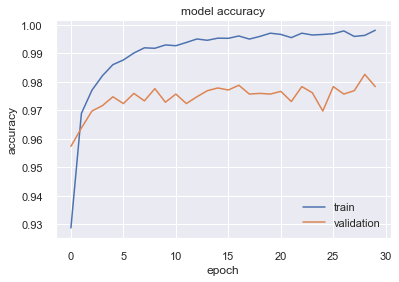

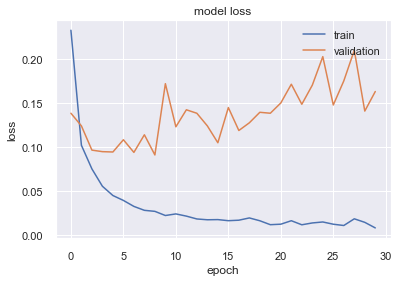

In [22]:
# Look at accuracy and loss history with 30 epochs

plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='lower right')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [23]:
# generate test data with 30 epochs

model2_Pred=(model2.predict(X_test))
results = np.argmax(model_Pred,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('../digit2/model2_Pred.csv',index=False)

### Neural Network 3 - 6 Dense Layers, 30 Epochs

Run with 30 epochs like in class example, but with 6 layers.

The score on kaggle is 0.97185, so increasing the number of layers resulted in a decrease in accuracy. Next round we decrease layers back to 4 and increase nodes.

In [59]:
start=datetime.now()
model3=tf.keras.Sequential()
model3.add(layers.Dense(392,input_dim=784,activation='relu'))
model3.add(layers.Dense(392,activation='relu'))
model3.add(layers.Dense(392,activation='relu'))
model3.add(layers.Dense(392,activation='relu'))
model3.add(layers.Dense(392,activation='relu'))
model3.add(layers.Dense(10,activation='softmax'))
model3.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['categorical_accuracy'])
history3=model3.fit(X,keras_Y, epochs=30, validation_data=(X_val, keras_Y_val))
end=datetime.now()
print("time:", end-start) 

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 6s 150us/sample - loss: 0.2611 - categorical_accuracy: 0.9229 - val_loss: 0.1741 - val_categorical_accuracy: 0.9510
Epoch 2/30
37800/37800 [==============================] - 5s 140us/sample - loss: 0.1279 - categorical_accuracy: 0.9635 - val_loss: 0.1828 - val_categorical_accuracy: 0.9548
Epoch 3/30
37800/37800 [==============================] - 5s 142us/sample - loss: 0.0976 - categorical_accuracy: 0.9728 - val_loss: 0.1247 - val_categorical_accuracy: 0.9612
Epoch 4/30
37800/37800 [==============================] - 5s 139us/sample - loss: 0.0797 - categorical_accuracy: 0.9779 - val_loss: 0.1237 - val_categorical_accuracy: 0.9636
Epoch 5/30
37800/37800 [==============================] - 5s 140us/sample - loss: 0.0648 - categorical_accuracy: 0.9830 - val_loss: 0.1022 - val_categorical_accuracy: 0.9738
Epoch 6/30
37800/37800 [==============================] - 5s 140us/sample - loss:

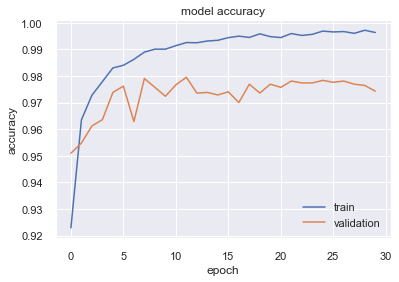

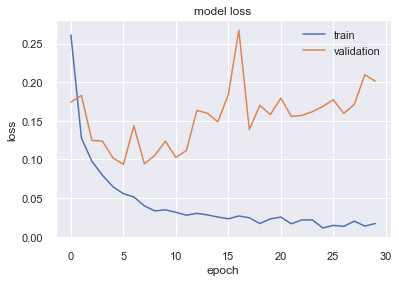

In [60]:
# Look at accuracy and loss history with 30 epochs, 6 layers

plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='lower right')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [61]:
# generate test data for model 3

model3_Pred=(model3.predict(X_test))
results = np.argmax(model_Pred,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('../digit2/model3_Pred.csv',index=False)

### Neural Network 4 - 4 Dense Layers, 784 nodes, 30 Epochs

Run with 30 epochs like in class example and back to 4 layers but with 784 nodes

The score on kaggle is 0.97185, so increasing the number of layers resulted in a decrease in accuracy. Next round we decrease layers back to 4 and increase nodes.

In [62]:
start=datetime.now()
model4=tf.keras.Sequential()
model4.add(layers.Dense(784,input_dim=784,activation='relu'))
model4.add(layers.Dense(784,activation='relu'))
model4.add(layers.Dense(784,activation='relu'))
model4.add(layers.Dense(10,activation='softmax'))
model4.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['categorical_accuracy'])
history4=model4.fit(X,keras_Y, epochs=30, validation_data=(X_val, keras_Y_val))
end=datetime.now()
print("time:", end-start) 

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 11s 279us/sample - loss: 0.2317 - categorical_accuracy: 0.9285 - val_loss: 0.1548 - val_categorical_accuracy: 0.9526
Epoch 2/30
37800/37800 [==============================] - 11s 279us/sample - loss: 0.1063 - categorical_accuracy: 0.9692 - val_loss: 0.1075 - val_categorical_accuracy: 0.9681
Epoch 3/30
37800/37800 [==============================] - 11s 283us/sample - loss: 0.0767 - categorical_accuracy: 0.9774 - val_loss: 0.0997 - val_categorical_accuracy: 0.9690
Epoch 4/30
37800/37800 [==============================] - 11s 285us/sample - loss: 0.0592 - categorical_accuracy: 0.9819 - val_loss: 0.1259 - val_categorical_accuracy: 0.9667
Epoch 5/30
37800/37800 [==============================] - 11s 280us/sample - loss: 0.0509 - categorical_accuracy: 0.9850 - val_loss: 0.1299 - val_categorical_accuracy: 0.9657
Epoch 6/30
37800/37800 [==============================] - 13s 354us/sample -

In [63]:
# generate test data for model 4

model4_Pred=(model4.predict(X_test))
results = np.argmax(model_Pred,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('../digit2/model4_Pred.csv',index=False)

### Model 5

For run 5 we try a model based on models shown in 2 sites:

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

We ran it for 30 epochs but progress flatlined after 7 epochs, so the code has been modified to 7 epochs to reduce code run time.

This model scored low in accuracy during validation, but still scored 0.97514 in the kaggle prediction, which was also better than the random forest with PCA.


In [44]:
X = X.reshape(X.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

X = X.astype('float32')
X_val = X_val.astype('float32')

X/=255
X_val/=255


model5=tf.keras.Sequential()

model5.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model5.add(layers.BatchNormalization(axis=-1))
model5.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model5.add(layers.BatchNormalization(axis=-1))
model5.add(layers.MaxPool2D(pool_size=(2,2)))
model5.add(layers.Dropout(0.25))

model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation = "relu"))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation = "softmax"))


# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model5.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5,min_lr=0.00001)


history5=model5.fit(X,keras_Y, epochs=7, batch_size = 86, validation_data=(X_val, keras_Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 98s 3ms/sample - loss: 2.3059 - accuracy: 0.1020 - val_loss: 3.1421 - val_accuracy: 0.1079
Epoch 2/30
37800/37800 [==============================] - 112s 3ms/sample - loss: 2.3040 - accuracy: 0.1080 - val_loss: 18.7948 - val_accuracy: 0.1079
Epoch 3/30
37800/37800 [==============================] - 108s 3ms/sample - loss: 2.3034 - accuracy: 0.1101 - val_loss: 22.2766 - val_accuracy: 0.0979
Epoch 4/30
37800/37800 [==============================] - 108s 3ms/sample - loss: 2.3023 - accuracy: 0.1110 - val_loss: 24.8054 - val_accuracy: 0.0981
Epoch 5/30
37800/37800 [==============================] - 108s 3ms/sample - loss: 2.3018 - accuracy: 0.1115 - val_loss: 2.6508 - val_accuracy: 0.0981
Epoch 6/30
37800/37800 [==============================] - 100s 3ms/sample - loss: 2.3017 - accuracy: 0.1113 - val_loss: 2.4745 - val_accuracy: 0.1069
Epoch 7/30
37800/37800 [=========================

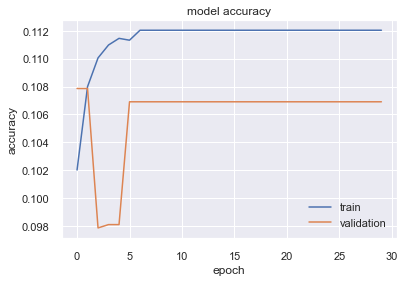

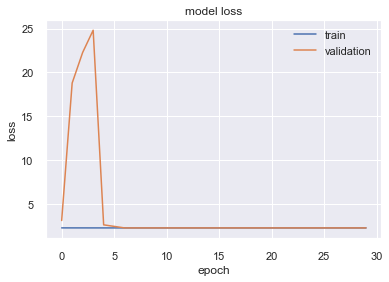

In [46]:
# Look at accuracy and loss of model 5

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='lower right')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [48]:
# generate kaggle submission data for model 3

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_test = X_val.astype('float32')

X_test/=255


model5_Pred=(model5.predict(X_test))
results = np.argmax(model5_Pred,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('../digit2/model5_Pred.csv',index=False)